In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Extracting features with fixed sampling rate (16000 Hz)...
Applying SMOTE for class balance...
Performing stratified 10-fold cross-validation...
Decision Tree Mean CV Accuracy: 0.3617
Random Forest Mean CV Accuracy: 0.7754
K-Nearest Neighbors Mean CV Accuracy: 0.5475
Naive Bayes Mean CV Accuracy: 0.4101
SVM Mean CV Accuracy: 0.7601
Logistic Regression Mean CV Accuracy: 0.7748

Best Model: RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=500, random_state=42)

Test Accuracy: 0.7728
Test Time: 0.1894 seconds
Classification Report:
                  precision    recall  f1-score   support

            aç       0.72      0.77      0.74        30
         alarmı       0.73      0.77      0.75        31
         arttır       0.84      0.68      0.75        31
   aydinlatmayı       0.92      0.74      0.82        31
          azalt       0.92      0.74      0.82        31
       düşür       0.71      0.77      0.74     

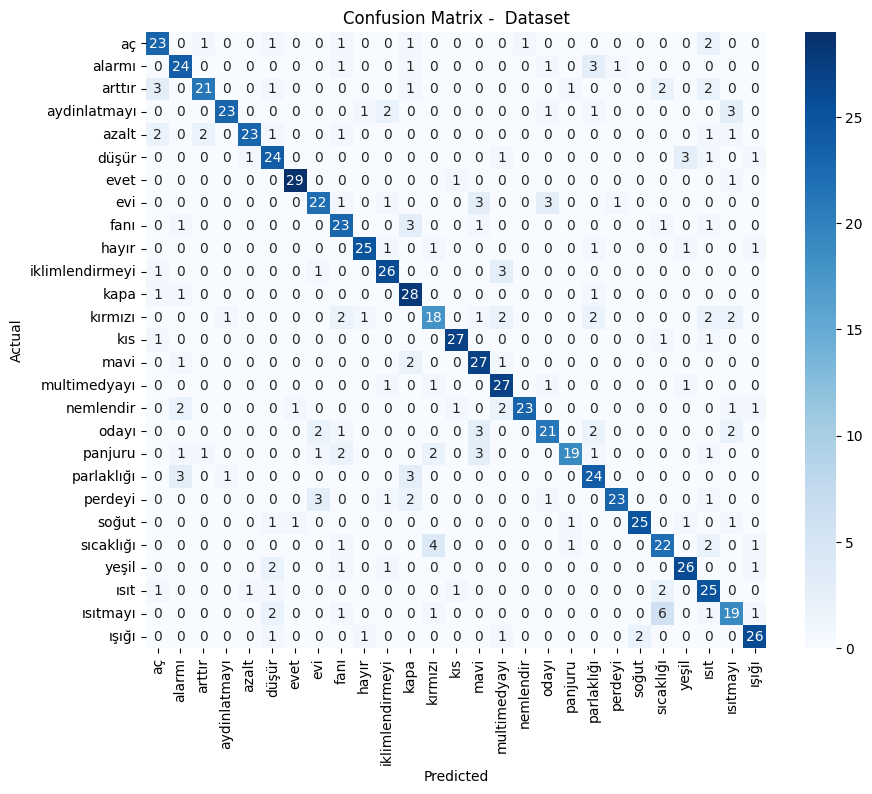

In [ ]:
import numpy as np
import os
import librosa
import time
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/drive/MyDrive/KAYIT_DOSYALARI-20250117T090128Z-001/ KAYIT_DOSYALARI'

# Özellik çıkarma fonksiyonu (zenginleştirilmiş)
def extract_features_with_fixed_sampling_rate(data_path, exclude_class="inohom", sr=16000):
    features, labels = [], []
    for command_dir in os.listdir(data_path):
        if command_dir == exclude_class:
            continue
        command_path = os.path.join(data_path, command_dir)
        if os.path.isdir(command_path):
            for file in os.listdir(command_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(command_path, file)

                    # Sabit sampling rate ile ses yükleme
                    y, _ = librosa.load(file_path, sr=sr, mono=True)

                    # Özellikler
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
                    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
                    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
                    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
                    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
                    rms = librosa.feature.rms(y=y)
                    delta_mfccs = librosa.feature.delta(mfccs)
                    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
                    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

                    # Özellikleri birleştir
                    combined_features = np.hstack([
                        np.mean(mfccs.T, axis=0), np.std(mfccs.T, axis=0),
                        np.mean(chroma.T, axis=0), np.std(chroma.T, axis=0),
                        np.mean(spectral_contrast.T, axis=0), np.std(spectral_contrast.T, axis=0),
                        np.mean(zero_crossing_rate.T, axis=0),
                        np.mean(spectral_rolloff.T, axis=0), np.std(spectral_rolloff.T, axis=0),
                        np.mean(spectral_centroid.T, axis=0), np.std(spectral_centroid.T, axis=0),
                        np.mean(rms.T, axis=0), np.std(rms.T, axis=0),
                        np.mean(delta_mfccs.T, axis=0), np.std(delta_mfccs.T, axis=0),
                        np.mean(delta2_mfccs.T, axis=0), np.std(delta2_mfccs.T, axis=0),
                        np.mean(onset_env), np.std(onset_env)
                    ])
                    features.append(combined_features)
                    labels.append(command_dir)
    return np.array(features), np.array(labels)

# Özellikleri çıkar
print("Extracting features with fixed sampling rate (16000 Hz)...")
features, labels = extract_features_with_fixed_sampling_rate(data_path, sr=16000)


# Verileri ölçeklendir
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# SMOTE ile sınıf dengesini sağla
print("Applying SMOTE for class balance...")
smote = SMOTE(random_state=42)
features_balanced, labels_balanced = smote.fit_resample(features_scaled, labels)

# Eğitim ve test setlerini böl
X_train, X_test, y_train, y_test = train_test_split(features_balanced, labels_balanced, test_size=0.2, stratify=labels_balanced, random_state=42)

# Modeller
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=30, class_weight='balanced',
                                          random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_split=5, class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='rbf', class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced',
                                            random_state=42)
}

# 10-katlı çapraz doğrulama
print("Performing stratified 10-fold cross-validation...")
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_model = None
best_accuracy = 0
for name, model in models.items():
    accuracies = []
    for train_index, val_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        model.fit(X_tr, y_tr)
        predictions = model.predict(X_val)
        acc = accuracy_score(y_val, predictions)
        accuracies.append(acc)

    mean_accuracy = np.mean(accuracies)
    print(f"{name} Mean CV Accuracy: {mean_accuracy:.4f}")

    if mean_accuracy > best_accuracy:
        best_model = model
        best_accuracy = mean_accuracy

print("\nBest Model:", best_model)

# Test seti üzerinde değerlendirme
start_time = time.time()
final_predictions = best_model.predict(X_test)
test_time = time.time() - start_time

print(f"\nTest Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print(f"Test Time: {test_time:.4f} seconds")
print("Classification Report:\n", classification_report(y_test, final_predictions))

# Karışıklık matrisi
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix -  Dataset")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Preparing data for LSTM...
Building LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 512)             │         546,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 27)                  │          13,851 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,398,235 (9.15 MB)

 Trainable params: 2,398,235 (9.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 84s 401ms/step - accuracy: 0.0984 - loss: 3.1174 - val_accuracy: 0.2102 - val_loss: 2.6489
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 78s 379ms/step - accuracy: 0.2381 - loss: 2.4502 - val_accuracy: 0.3273 - val_loss: 2.2115
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 365ms/step - accuracy: 0.4060 - loss: 1.9168 - val_accuracy: 0.3453 - val_loss: 2.0841
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 83s 373ms/step - accuracy: 0.5188 - loss: 1.5944 - val_accuracy: 0.4595 - val_loss: 1.8170
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 63s 378ms/step - accuracy: 0.6056 - loss: 1.2594 - val_accuracy: 0.5030 - val_loss: 1.6756
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 83s 386ms/step - accuracy: 0.6899 - loss: 0.9473 - val_accuracy: 0.5105 - val_loss: 1.6551
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 62s 369ms/step - accuracy: 0.7698 - loss: 0.6999 - val_accuracy: 0.5180 - val_loss: 1.7420
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.8144 - loss: 0

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step

LSTM Test Accuracy: 0.6166
LSTM Test Time: 5.1744 seconds
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.37      0.42        30
           1       0.64      0.58      0.61        31
           2       0.50      0.48      0.49        31
           3       0.85      0.55      0.67        31
           4       0.58      0.68      0.63        31
           5       0.60      0.58      0.59        31
           6       0.74      0.84      0.79        31
           7       0.61      0.61      0.61        31
           8       0.50      0.40      0.44        30
           9       0.80      0.80      0.80        30
          10       0.82      0.74      0.78        31
          11       0.46      0.71      0.56        31
          12       0.54      0.65      0.59        31
          13       0.57      0.70      0.63        30
          14       0.53      0.26      0.35        31
       

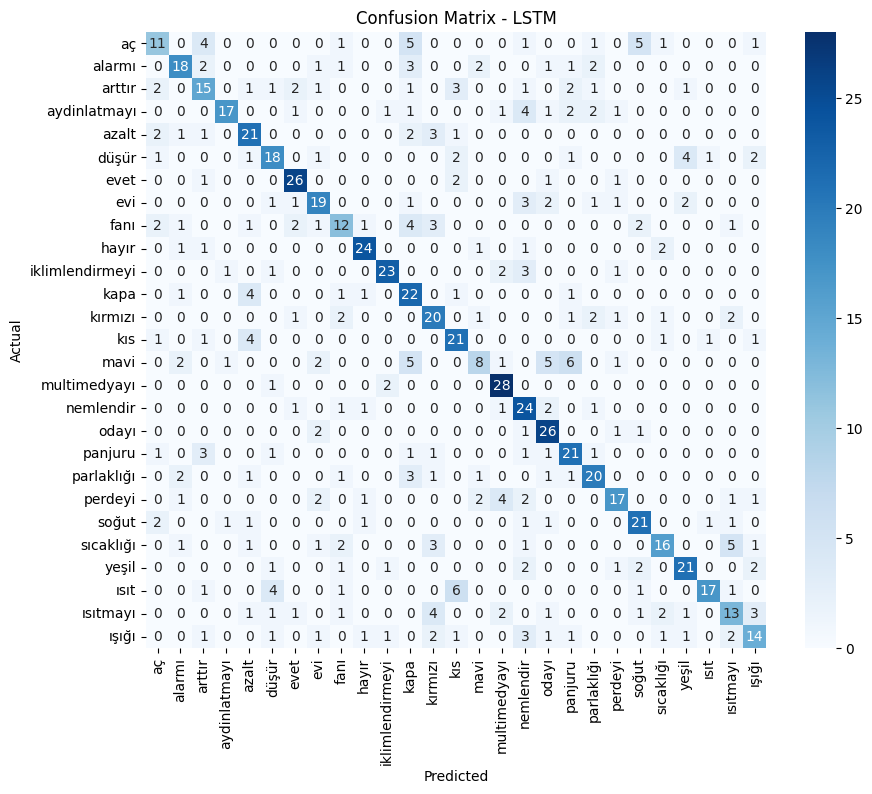

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential

print("Preparing data for LSTM...")
X_train, X_test, y_train, y_test = train_test_split(
    features_balanced, labels_balanced, test_size=0.2, stratify=labels_balanced, random_state=42
)



# SMOTE ile sınıf dengesini sağla
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Veriyi tekrar ölçeklendir
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

def pad_or_crop_features(features, target_size):
    current_size = features.shape[1]
    if current_size < target_size:
        # Sıfırlarla doldur
        pad_width = target_size - current_size
        features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
    elif current_size > target_size:
        # Fazlalıkları kırp
        features = features[:, :target_size]
    return features

# 100 özellik boyutuna getir
X_train = pad_or_crop_features(X_train, target_size=200)
X_test = pad_or_crop_features(X_test, target_size=200)



# LSTM için 3D şekline dönüştür
X_train_lstm = X_train.reshape(X_train.shape[0], 20, 10) #change
X_test_lstm = X_test.reshape(X_test.shape[0], 20, 10) #change


# Sınıfları kategorik hale getir
label_map = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_cat = tf.keras.utils.to_categorical([label_map[label] for label in y_train])
y_test_cat = tf.keras.utils.to_categorical([label_map[label] for label in y_test])



# Model 2: LSTM
print("Building LSTM model...")
lstm_model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(10, 10)),
    Bidirectional(LSTM(256)),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train LSTM model
lstm_history = lstm_model.fit(X_train_lstm, y_train_cat, validation_split=0.2, epochs=50, batch_size=16)

# Save LSTM model
lstm_model.save("lstm_model.h5")

# Test LSTM model
start_time = time.time()
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_test_time = time.time() - start_time
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)
y_test_classes = [label_map[label] for label in y_test]
# LSTM evaluation
lstm_accuracy = accuracy_score(y_test_classes, lstm_pred_classes)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")
print(f"LSTM Test Time: {lstm_test_time:.4f} seconds")
print("LSTM Classification Report:\n", classification_report(y_test_classes, lstm_pred_classes))

# Plot LSTM confusion matrix
conf_matrix_lstm = confusion_matrix(y_test_classes, lstm_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Loading data...
Building 2D CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 38, 98, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 19, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 19, 49, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 47, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 23, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 23552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,029,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │           6,939 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,111,259 (23.31 MB)

 Trainable params: 6,111,131 (23.31 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 52s 620ms/step - accuracy: 0.0536 - loss: 4.4461 - val_accuracy: 0.0799 - val_loss: 3.2463
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 77s 567ms/step - accuracy: 0.1068 - loss: 3.0559 - val_accuracy: 0.1897 - val_loss: 2.7546
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 575ms/step - accuracy: 0.2454 - loss: 2.5374 - val_accuracy: 0.4091 - val_loss: 2.1008
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 565ms/step - accuracy: 0.3536 - loss: 2.1022 - val_accuracy: 0.4671 - val_loss: 1.6917
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 583ms/step - accuracy: 0.5060 - loss: 1.6416 - val_accuracy: 0.5737 - val_loss: 1.4917
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 582ms/step - accuracy: 0.5627 - loss: 1.3826 - val_accuracy: 0.6489 - val_loss: 1.2442
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 569ms/step - accuracy: 0.6110 - loss: 1.1782 - val_accuracy: 0.6536 - val_loss: 1.1261
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 81s 548ms/step - accuracy: 0.6808 - loss: 0.9403 - val_accu

Testing CNN model...
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step

CNN Test Accuracy: 0.7381
CNN Test Time: 5.1883 seconds
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.77      0.68        30
           1       0.50      0.71      0.59        31
           2       0.80      0.52      0.63        31
           3       0.87      0.87      0.87        31
           4       0.82      0.87      0.84        31
           5       0.65      0.71      0.68        31
           6       0.80      0.62      0.70        13
           7       0.76      0.81      0.78        31
           8       0.49      0.68      0.57        31
           9       0.70      0.54      0.61        13
          10       0.83      0.67      0.74        30
          11       0.79      0.71      0.75        31
          12       0.70      0.84      0.76        31
          13       0.89      0.77      0.83        31
          14       0.83      0.77      0.8

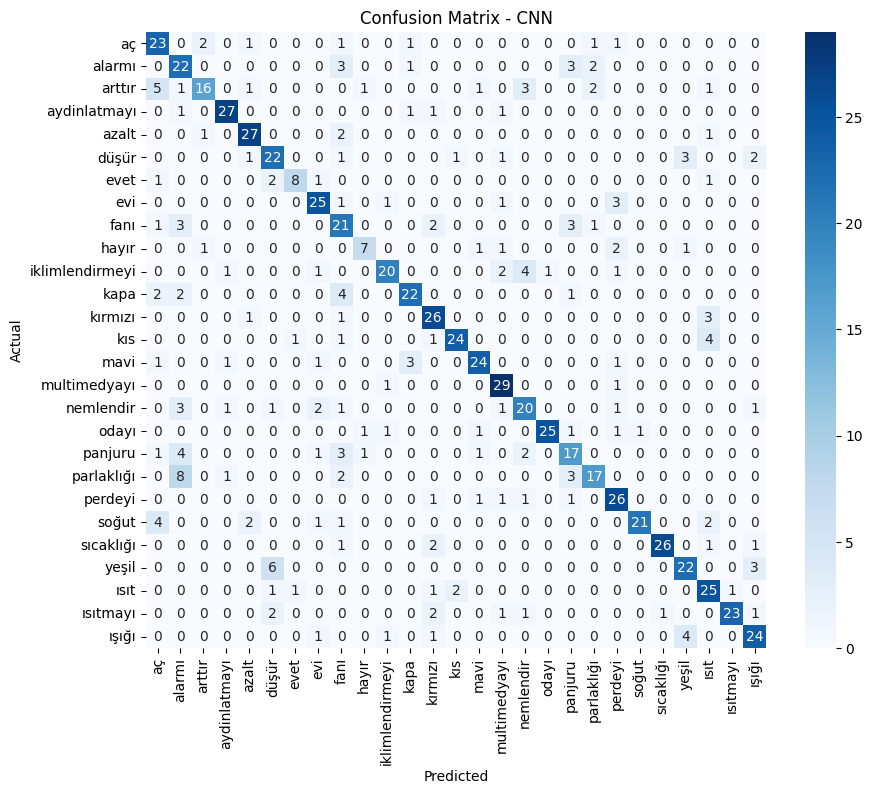

In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout,
                                     BatchNormalization, Bidirectional)
import time

# Define paths and constants
data_path = '/content/drive/MyDrive/KAYIT_DOSYALARI-20250117T090128Z-001/ KAYIT_DOSYALARI'
SAMPLING_RATE = 16000
CLASSES_TO_EXCLUDE = ["inohom"]
TARGET_CLASSES = 27

# Function to extract MFCCs
def extract_features(file_path, n_mfcc=40, max_pad_len=100):
    y, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    return mfccs

# Load and preprocess data
def load_data(data_path):
    features, labels = [], []
    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith(".wav"):
                label = os.path.basename(root)
                if label not in CLASSES_TO_EXCLUDE:
                    file_path = os.path.join(root, file)
                    mfcc = extract_features(file_path)
                    features.append(mfcc)
                    labels.append(label)
    return np.array(features), np.array(labels)

# Load data
print("Loading data...")
X, y = load_data(data_path)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = tf.keras.utils.to_categorical(y_encoded)

# Split data stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, stratify=y_encoded, random_state=42
)

# Reshape for CNN and LSTM
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]



# Model 1: 2D CNN
print("Building 2D CNN model...")
cnn_model = Sequential([
    Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(40, 100, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(TARGET_CLASSES, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Train CNN model
cnn_history = cnn_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=20, batch_size=32)

# Save CNN model
cnn_model.save("cnn_model_voice.h5")

# Test CNN model
print("Testing CNN model...")
start_time = time.time()
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_test_time = time.time() - start_time
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# CNN evaluation
cnn_accuracy = accuracy_score(y_test_classes, cnn_pred_classes)
print(f"\nCNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"CNN Test Time: {cnn_test_time:.4f} seconds")
print("CNN Classification Report:\n", classification_report(y_test_classes, cnn_pred_classes))

# Plot CNN confusion matrix
conf_matrix_cnn = confusion_matrix(y_test_classes, cnn_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()








In [1]:
!unzip "/content/propeller_dataset_980_segmented.zip" -d propeller_dataset

Archive:  /content/propeller_dataset_980_segmented.zip
   creating: propeller_dataset/output/
  inflating: propeller_dataset/output/100.0_110.0_healthynotchlong_indoor_clear_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthynotchlong_indoor_noisy_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthynotchlong_outdoor_noisy_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthynotchshort_indoor_clear_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthynotchshort_indoor_noisy_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthynotchshort_outdoor_noisy_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthyscracth_indoor_clear_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthyscracth_indoor_noisy_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthyscracth_outdoor_noisy_980.csv  
  inflating: propeller_dataset/output/100.0_110.0_healthysinglecutlong_indoor_clear_980.csv  
  

Performing stratified 10-fold cross-validation...
Decision Tree Mean CV Accuracy: 0.5051
Random Forest Mean CV Accuracy: 0.6564
K-Nearest Neighbors Mean CV Accuracy: 0.4744
Naive Bayes Mean CV Accuracy: 0.1949
SVM Mean CV Accuracy: 0.3231
Logistic Regression Mean CV Accuracy: 0.4462

Best Model: RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_split=5, n_estimators=500, random_state=42)

Test Accuracy: 0.7083
Test Time: 0.0377 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.67      0.67      0.67         9
           2       0.50      0.60      0.55        10
           3       0.62      0.50      0.56        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00         9
           6       0.83      1.00      0.91        10
           7       0.75      0.60      0.67        10
  

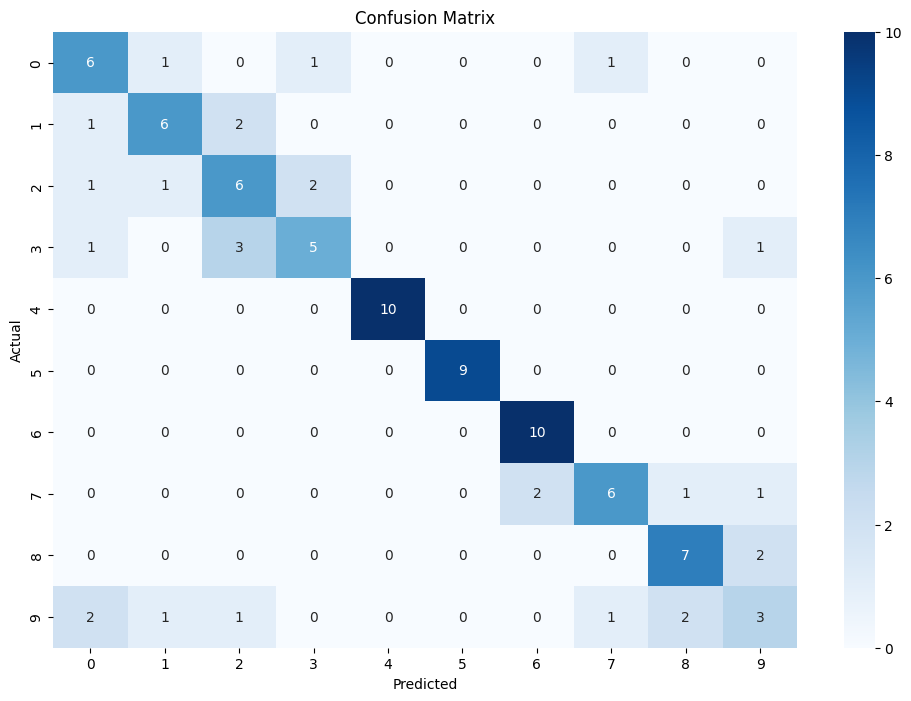

In [2]:
import numpy as np
import pandas as pd
import os
import time
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.utils import to_categorical

# Define dataset path
data_path = "/content/propeller_dataset/output"

# Feature Extraction for Sensor Data
def extract_sensor_features(df):
    return np.hstack([
        df.mean(axis=0),
        df.std(axis=0),
        df.min(axis=0),
        df.max(axis=0),
    ])

sensor_data = []
sensor_labels = []
speed_ranges = []
for file in os.listdir(data_path):
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    features = extract_sensor_features(df.iloc[:, 1:-1])
    label = df.iloc[0, -1]
    speed_range = df.iloc[0, 0]  # Assuming speed range is in the first column
    sensor_data.append(features)
    sensor_labels.append(label)
    speed_ranges.append(speed_range)

sensor_data = np.array(sensor_data)
sensor_labels = np.array(sensor_labels)
speed_ranges = np.array(speed_ranges)

# Encoding sensor labels
label_encoder_sensor = LabelEncoder()
sensor_labels_encoded = label_encoder_sensor.fit_transform(sensor_labels)
label_map = {i: label for i, label in enumerate(label_encoder_sensor.classes_)}

# Encoding speed range labels
label_encoder_speed = LabelEncoder()
speed_ranges_encoded = label_encoder_speed.fit_transform(speed_ranges)

# Split dataset
X_train, X_test, y_train, y_test, speed_train, speed_test = train_test_split(
    sensor_data, sensor_labels_encoded, speed_ranges_encoded, test_size=0.2, stratify=sensor_labels_encoded, random_state=42
)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=30, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_split=5, class_weight='balanced', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, weights='distance'),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='rbf', class_weight='balanced', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
}

# Perform 10-fold cross-validation
print("Performing stratified 10-fold cross-validation...")
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

best_model = None
best_accuracy = 0
for name, model in models.items():
    accuracies = []
    for train_index, val_index in skf.split(X_train_scaled, y_train_balanced):
        X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_tr, y_val = y_train_balanced[train_index], y_train_balanced[val_index]

        model.fit(X_tr, y_tr)
        predictions = model.predict(X_val)
        acc = accuracy_score(y_val, predictions)
        accuracies.append(acc)

    mean_accuracy = np.mean(accuracies)
    print(f"{name} Mean CV Accuracy: {mean_accuracy:.4f}")

    if mean_accuracy > best_accuracy:
        best_model = model
        best_accuracy = mean_accuracy

print("\nBest Model:", best_model)

# Test set evaluation
start_time = time.time()
final_predictions = best_model.predict(X_test_scaled)
test_time = time.time() - start_time

print(f"\nTest Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print(f"Test Time: {test_time:.4f} seconds")
print("Classification Report:\n", classification_report(y_test, final_predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 7, 3, 64)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 3, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 2, 128)           │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,834 (397.79 KB)

 Trainable params: 101,706 (397.29 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.1286 - loss: 2.4358 - val_accuracy: 0.2051 - val_loss: 2.2976
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3821 - loss: 1.8810 - val_accuracy: 0.2949 - val_loss: 2.2455
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4616 - loss: 1.4739 - val_accuracy: 0.4231 - val_loss: 2.1881
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5144 - loss: 1.4335 - val_accuracy: 0.3974 - val_loss: 2.1563
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4355 - loss: 1.4133 - val_accuracy: 0.4744 - val_loss: 2.0996
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5787 - loss: 1.2145 - val_accuracy: 0.3974 - val_loss: 2.0852
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5722 - loss: 1.1813 - val_accuracy: 0.4487 - val_loss: 2.0491
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5794 - loss: 1.0618 - val_accuracy: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 

CNN Test Accuracy: 0.5625
CNN Test Time: 0.3876 seconds
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.44      0.47         9
           1       0.46      0.67      0.55         9
           2       0.38      0.50      0.43        10
           3       0.78      0.70      0.74        10
           4       0.77      1.00      0.87        10
           5       0.58      0.78      0.67         9
           6       0.44      0.40      0.42        10
           7       0.50      0.30      0.38        10
           8       0.60      0.67      0.63         9
           9       0.67      0.20      0.31        10

    accuracy                           0.56        96
   macro avg       0.57      0.57      0.55        96
weighted avg       0.57      0.56      0.54        96



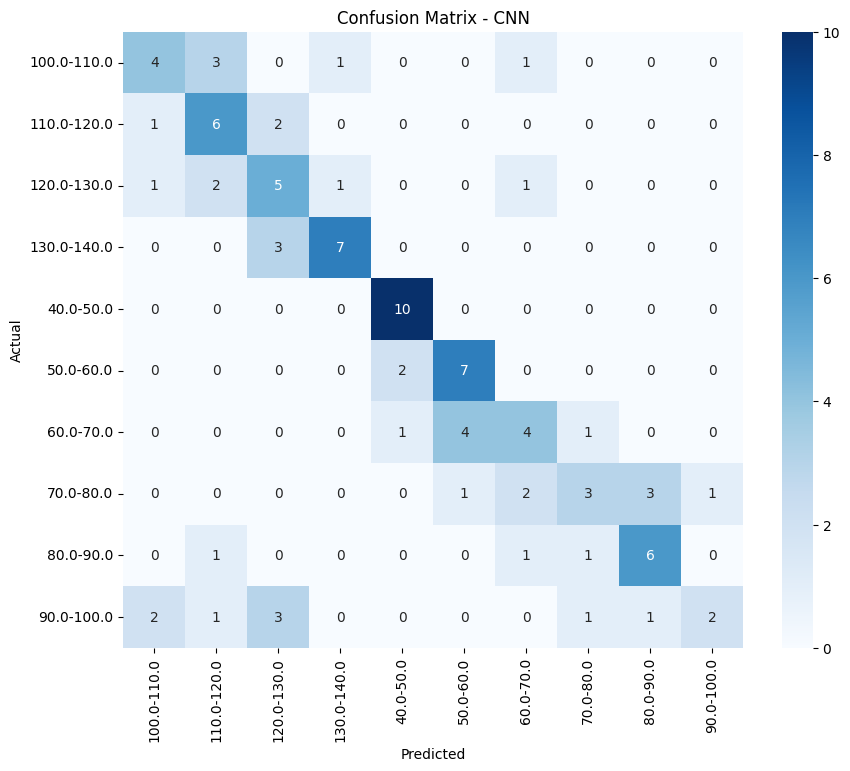

In [3]:
# Reshape for CNN
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], 8, 4, 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], 8, 4, 1)

y_train_cat = to_categorical(y_train_balanced, num_classes=len(label_map))
y_test_cat = to_categorical(y_test, num_classes=len(label_map))

# Build 2D CNN Model
cnn_model = Sequential([
    Conv2D(64, kernel_size=(2,2), activation='relu', input_shape=(8, 4, 1)),
    MaxPooling2D(pool_size=(2,1)),  # Adjust pooling to preserve width
    BatchNormalization(),

    Conv2D(128, kernel_size=(2,2), activation='relu'),
    MaxPooling2D(pool_size=(2,1)),  # Prevent too much shrinking

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(label_map), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Train CNN model
cnn_model.fit(X_train_cnn, y_train_cat, validation_split=0.2, epochs=100, batch_size=32)
cnn_model.save("cnn_model.h5")

# Test CNN model
start_time = time.time()
cnn_predictions = cnn_model.predict(X_test_cnn)
cnn_test_time = time.time() - start_time
cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

print(f"\nCNN Test Accuracy: {accuracy_score(y_test, cnn_pred_classes):.4f}")
print(f"CNN Test Time: {cnn_test_time:.4f} seconds")
print("CNN Classification Report:\n", classification_report(y_test, cnn_pred_classes))

# Confusion Matrix
conf_matrix_cnn = confusion_matrix(y_test, cnn_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Building LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 8, 512)              │         534,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 512)                 │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,377,226 (9.07 MB)

 Trainable params: 2,377,226 (9.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.1169 - loss: 2.2565 - val_accuracy: 0.1026 - val_loss: 2.0976
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.2610 - loss: 1.9635 - val_accuracy: 0.1538 - val_loss: 1.9183
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.2799 - loss: 1.8283 - val_accuracy: 0.3333 - val_loss: 1.8277
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.3207 - loss: 1.6655 - val_accuracy: 0.2436 - val_loss: 1.7649
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 0.3708 - loss: 1.5791 - val_accuracy: 0.3974 - val_loss: 1.7368
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.3141 - loss: 1.6555 - val_accuracy: 0.3205 - val_loss: 1.8322
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.3897 - loss: 1.5194 - val_accuracy: 0.5256 - val_loss: 1.6248
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.4648 - loss: 1.3577 - val_acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

LSTM Test Accuracy: 0.5312
LSTM Test Time: 1.3183 seconds
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.50      0.56      0.53         9
           2       0.40      0.40      0.40        10
           3       0.57      0.40      0.47        10
           4       0.83      1.00      0.91        10
           5       0.64      0.78      0.70         9
           6       0.56      0.50      0.53        10
           7       0.44      0.40      0.42        10
           8       0.50      0.56      0.53         9
           9       0.33      0.40      0.36        10

    accuracy                           0.53        96
   macro avg       0.53      0.53      0.52        96
weighted avg       0.53      0.53      0.52        96



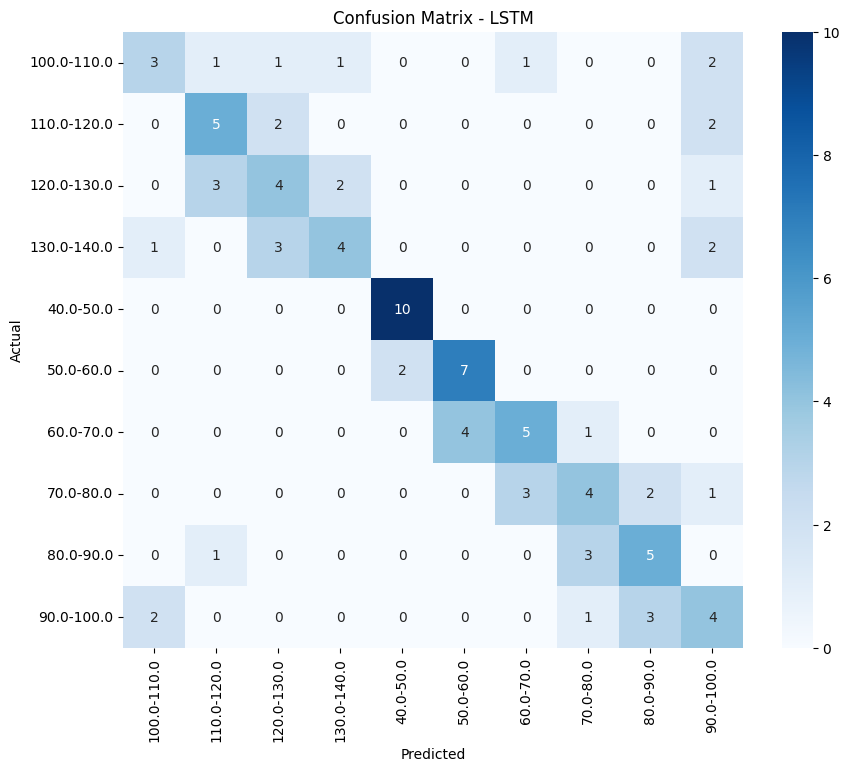

In [4]:
# LSTM Model
print("Building LSTM model...")
# Reshape for LSTM
time_steps = 8  # Adjust based on data
n_features = X_train_scaled.shape[1] // time_steps

X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], time_steps, n_features)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], time_steps, n_features)

# Convert Labels to Categorical
y_train_cat = to_categorical(y_train_balanced, num_classes=len(label_map))
y_test_cat = to_categorical(y_test, num_classes=len(label_map))

# Define Fixed LSTM Model
lstm_model = Sequential([
    Input(shape=(time_steps, n_features)),  # ✅ Fixed: Explicit input shape
    Bidirectional(LSTM(256, return_sequences=True)),
    Bidirectional(LSTM(256)),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(len(label_map), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train LSTM Model
lstm_history = lstm_model.fit(X_train_lstm, y_train_cat, validation_split=0.2, epochs=100, batch_size=16)

# Save Model
lstm_model.save("lstm_model.h5")

# Test LSTM Model
start_time = time.time()
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_test_time = time.time() - start_time
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)

# Evaluate LSTM Model
lstm_accuracy = accuracy_score(y_test, lstm_pred_classes)
print(f"\nLSTM Test Accuracy: {lstm_accuracy:.4f}")
print(f"LSTM Test Time: {lstm_test_time:.4f} seconds")
print("LSTM Classification Report:\n", classification_report(y_test, lstm_pred_classes))

# Plot LSTM Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_test, lstm_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()